# Summary of the Epilepsy Knowlege Assembly

This notebook was used to generate **Table 2** of the manuscript, "A systematic approach for identifying shared mechanisms in epilepsy and its comorbidities" from Hoyt and Domingo-Fernandez *et. al*, 2018. In this example, we'll summarize the NeuroMMSig subgraphs in the Epilepsy Knowledge Assembly.

## Code Provenance

This notebook uses Python 3 and the currently most up-to-date versions of [PyBEL](https://github.com/pybel/pybel) and [PyBEL Tools](https://github.com/pybel/pybel-tools).

In [26]:
import os
import sys
import time

import matplotlib.pyplot as plt
import pandas as pd
import pybel
import pybel.utils 
import pybel_tools.utils
import seaborn as sns

from pybel_tools import selection
from pybel import Manager
from pybel.struct import get_pubmed_identifiers
from pybel_tools.mutation import infer_central_dogma
from pybel_tools.summary import info_json, info_list, get_citation_years
from pybel_tools.utils import barh, barv

In [27]:
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [28]:
print(sys.version)

3.6.4 (default, Mar 22 2018, 13:54:22) 
[GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.39.2)]


In [29]:
print(time.asctime())

Tue Mar 27 20:33:24 2018


In [30]:
print(pybel.utils.get_version())

0.11.2-dev


In [31]:
print(pybel_tools.utils.get_version())

0.5.2-dev


In [32]:
manager = Manager()
manager

<Manager connection=mysql+mysqldb://root@localhost/pybel?charset=utf8>

# Data

This notebook uses the Epilepsy Knowledge Assembly, which is available from the Fraunhofer SCAI Department of Bioinformatics [downloads page](https://www.scai.fraunhofer.de/en/business-research-areas/bioinformatics/downloads.html).

In [33]:
bel_url = 'https://www.scai.fraunhofer.de/content/dam/scai/de/downloads/bioinformatik/epilepsy.bel'

The following local file path is defined for caching

In [34]:
pickle_path = 'epilepsy.gpickle'

In [35]:
%%time

if os.path.exists(pickle_path): # load from pre-compiled
    graph = pybel.from_pickle(pickle_path)
else:
    graph = pybel.from_url(bel_url)
    pybel.to_pickle(graph, pickle_path) # cache for later

CPU times: user 135 ms, sys: 11.3 ms, total: 146 ms
Wall time: 144 ms


There are a couple semantic errors in the document. Nobody's perfect!

In [36]:
print(graph)

Epilepsy Knowledge Assembly v1.0.0


## Processing

Ensure all proteins have their corresponding mRNAs, and all RNAs have their corresponding genes.

In [37]:
infer_central_dogma(graph)

# Summary

## Nodes and Edges

A summary of the types of nodes a edges is output using matplotlib and pbt.summary.plot_summary. It is displayed with beautiful vector graphics using a tweak at the beginning of the notebook: %config InlineBackend.figure_format = 'svg'.

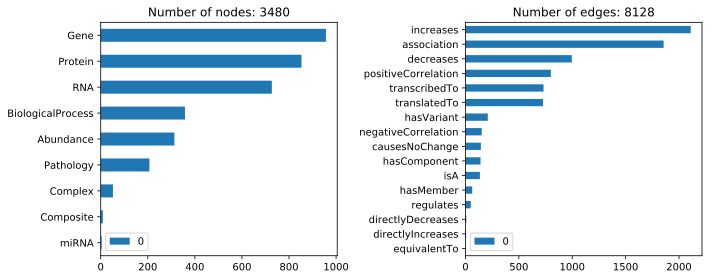

In [38]:
pybel_tools.summary.plot_summary(graph, plt, logx=False, figsize=(10, 4))
plt.show()

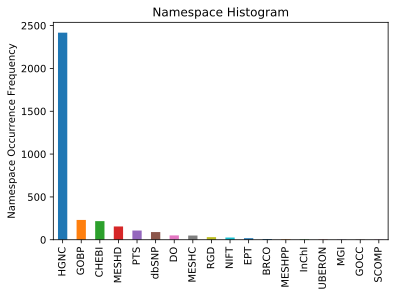

In [39]:
namespace_counter = pybel.struct.summary.count_namespaces(graph)

pd.Series(namespace_counter).sort_values(ascending=False).plot(kind='bar')
plt.title('Namespace Histogram')
plt.ylabel('Namespace Occurrence Frequency')
plt.show()

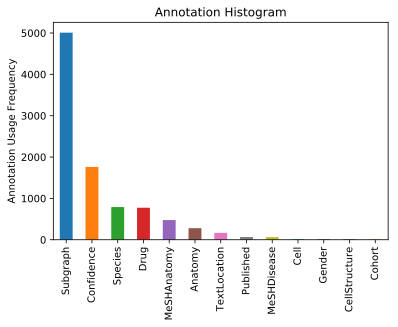

In [40]:
annotation_counter = pybel_tools.summary.count_annotations(graph)

# Problem with encoding underscores in latex. Disregard this
annotation_counter = {k.replace('_', ''): v for k, v in annotation_counter.items()}

pd.Series(annotation_counter).sort_values(ascending=False).plot(kind='bar')
plt.title('Annotation Histogram')
plt.ylabel('Annotation Usage Frequency')
plt.show()

## Citations

Count the number of citations in the graph

In [41]:
pmids = get_pubmed_identifiers(graph)
len(pmids)

641

Plot the citations on a time series

In [42]:
pybel.manager.enrich_pubmed_citations(manager, graph)
citation_years = get_citation_years(graph)

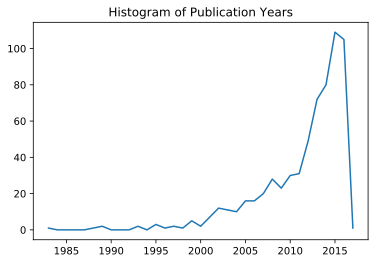

In [43]:
plt.title('Histogram of Publication Years')
plt.plot(*zip(*citation_years))
plt.show()

## Stratified by Subgraph

Split the graph into subgraphs using the `Subgraph` annotation.

In [44]:
subgraphs = selection.get_subgraphs_by_annotation(graph, 'Subgraph')
len(subgraphs)

33

In [45]:
def fix_columns(df_):
    for c in ['Nodes', 'Edges', 'Citations', 'Components']:
        df_[c] = df_[c].astype(int)

Using the [`pybel_tools.summary.info_json`](http://pybel-tools.readthedocs.io/en/latest/summary.html#pybel_tools.summary.info_json) function, the nodes, edges, citations, authors, average degree, and network density of a graph are entered in a dictionary. Edges that were not classified in a subgraph were labeled as "Undefined."

In [46]:
data = {
    subgraph_name.capitalize(): info_json(subgraph)
    for subgraph_name, subgraph in subgraphs.items()
}
df_summary = pd.DataFrame(data).T
del df_summary['Authors']
fix_columns(df_summary)

Several histograms of the subgraphs are presented, excluding edges labeled as "Undefined."

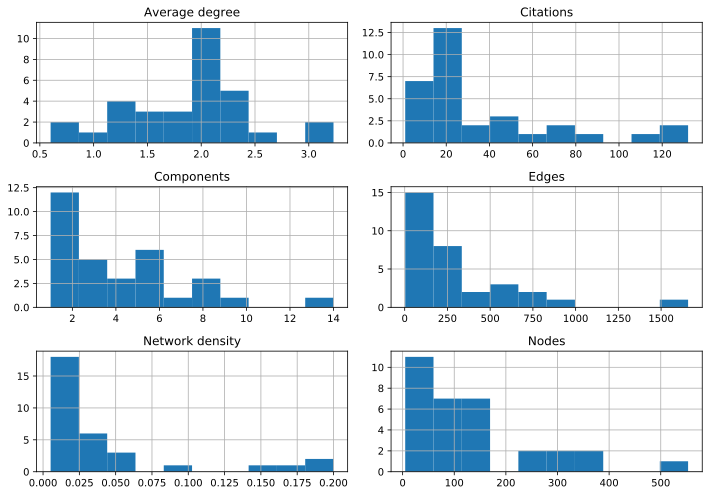

In [47]:
df_summary[df_summary.index != 'Undefined'].hist(figsize=(10,7))
plt.tight_layout()
plt.show()

The subgraph is ammended with total information and shown as a table.

In [48]:
df_total = pd.DataFrame({'Total': info_json(graph)}).T
del df_total['Compilation warnings']
del df_total['Authors']
fix_columns(df_total)

In [49]:
df = pd.concat([df_summary, df_total])
df

,Average degree,Citations,Components,Edges,Network density,Nodes
Adaptive immune system subgraph,1.000000,5,4,12,0.090909,12
Adenosine signaling subgraph,2.026316,15,3,154,0.027018,76
Apoptosis signaling subgraph,2.206140,115,5,503,0.009719,228
Brain_derived neurotrophic factor signaling subgraph,1.920000,29,1,144,0.025946,75
Calcium dependent subgraph,2.576159,73,8,778,0.008559,302
Chromatin organization subgraph,1.250000,2,2,10,0.178571,8
Energy metabolic subgraph,1.945055,24,4,177,0.021612,91
Estradiol metabolism,1.142857,1,2,8,0.190476,7
G-protein-mediated signaling,1.820513,26,5,142,0.023643,78
Gaba subgraph,2.422053,57,2,637,0.009244,263


The dataframe can be output to CSV, or a wide variety of other formats using pandas.

In [50]:
path = os.path.join(os.path.expanduser('~'), 'Desktop', 'subgraph_summary.csv')
df[['Nodes', 'Edges', 'Components', 'Citations']].to_csv(path)